## LAB2

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [25]:
dataset = pd.read_csv("dataset_cleaned.csv")

firstVisits = dataset.loc[dataset['Visit'] == 1]

print(firstVisits.loc[0:15, ['Subject ID', 'Group', 'Visit' , 'CDR']])

   Subject ID        Group  Visit  CDR
0   OAS2_0001  Nondemented      1  0.0
2   OAS2_0002     Demented      1  0.5
5   OAS2_0004  Nondemented      1  0.0
7   OAS2_0005  Nondemented      1  0.0
10  OAS2_0007     Demented      1  0.5
13  OAS2_0008  Nondemented      1  0.0
15  OAS2_0009     Demented      1  0.5


Sve osobe koje su u nekom kasnijem posjetu bile zabilježene kao 'Converted' se na kraju klasificiraju isto kao i osobe označene s 'Demented' od početka

In [26]:
dataset['Group'] = dataset['Group'].replace(['Converted'], ['Demented'])

print(dataset.loc[32:42,:])

    Unnamed: 0 Subject ID         MRI ID        Group  Visit  MR Delay M/F  \
32          32  OAS2_0017  OAS2_0017_MR5  Nondemented      5      2400   M   
33          33  OAS2_0018  OAS2_0018_MR1     Demented      1         0   F   
34          34  OAS2_0018  OAS2_0018_MR3     Demented      3       489   F   
35          35  OAS2_0018  OAS2_0018_MR4     Demented      4      1933   F   
36          36  OAS2_0020  OAS2_0020_MR1     Demented      1         0   M   
37          37  OAS2_0020  OAS2_0020_MR2     Demented      2       756   M   
38          38  OAS2_0020  OAS2_0020_MR3     Demented      3      1563   M   
39          39  OAS2_0021  OAS2_0021_MR1     Demented      1         0   M   
40          40  OAS2_0021  OAS2_0021_MR2     Demented      2      1164   M   
41          41  OAS2_0022  OAS2_0022_MR1  Nondemented      1         0   F   
42          42  OAS2_0022  OAS2_0022_MR2  Nondemented      2       828   F   

    Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
32   86    

### STRING u INT

Da se moze provesti binarna klasifikacija  
Oznaka 'Grupa' je ono što će se pokušati pogoditi

In [27]:
group_map = {"Demented": 1, "Nondemented": 0}

dataset['Group'] = dataset['Group'].map(group_map)
dataset['M/F'] = dataset['M/F'].replace(['F','M'], [0,1])

print(dataset.loc[32:42,:])

    Unnamed: 0 Subject ID         MRI ID  Group  Visit  MR Delay  M/F  Age  \
32          32  OAS2_0017  OAS2_0017_MR5      0      5      2400    1   86   
33          33  OAS2_0018  OAS2_0018_MR1      1      1         0    0   87   
34          34  OAS2_0018  OAS2_0018_MR3      1      3       489    0   88   
35          35  OAS2_0018  OAS2_0018_MR4      1      4      1933    0   92   
36          36  OAS2_0020  OAS2_0020_MR1      1      1         0    1   80   
37          37  OAS2_0020  OAS2_0020_MR2      1      2       756    1   82   
38          38  OAS2_0020  OAS2_0020_MR3      1      3      1563    1   84   
39          39  OAS2_0021  OAS2_0021_MR1      1      1         0    1   72   
40          40  OAS2_0021  OAS2_0021_MR2      1      2      1164    1   76   
41          41  OAS2_0022  OAS2_0022_MR1      0      1         0    0   61   
42          42  OAS2_0022  OAS2_0022_MR2      0      2       828    0   64   

    EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
32    12  3.0  2

### Podjela na train i test set

The data had been preprocessed, and we randomly divided it into an 80:20 ratio, with 80% going to training and 20% gone to testing

In [28]:
model_features = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']    # "MRI ID", - da mogu lijepo ispisat
model_prediction_class = ['Group']

X = dataset[model_features].values
y = dataset[model_prediction_class].values

# random_state sets a seed to the random generator, so that  train-test splits are always deterministic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44)
# Ispadne ih 74 u X_test setu : 373 * 0.2 = 74.6
""" 
i = 0
for ex in X_test:
    print(str(i) + ". : " + str(ex))
    i = i + 1
"""

' \ni = 0\nfor ex in X_test:\n    print(str(i) + ". : " + str(ex))\n    i = i + 1\n'

### Razlog odabira značajki

MMSE - Non-demented group had much higher MMSE (Mini-Mental State Examination) scores than those with dementia - from article (Figure 4)  
Gender - Men are more likely than women to have dementia  
ASF, eTIV - Disease causes brain tissue to shrink -> demented people have smallerbrain volume ratio  
EDUC - Demented patients were less educated  
Age - Dementia is a disease more common for older people  

### Funkcije za izgradnju matrice zabune i ROC krivulje

Matrica zabune govori koliko je primjera iz test seta bilo točno klasificirano (true negative i true positive), a koliko njih krivo (false positive i false negative) - pošto je train skup dio ulaznih podataka koje smo već vidjeli, znamo koju oznaku klase očekujemo; predviđena vrijednost je dobivena predikcijom modela koji je treniran na train skupu primjera.  
  
ROC krivulja 

In [29]:
def performance_report(model):
    model_test = model.predict(X_test)
    accuracyScore = metrics.accuracy_score(y_test, model_test)
    print("\nAcuuracy Of the Model: " +  str(accuracyScore) + "\n")
    confusionMatrix = metrics.confusion_matrix(y_test, model_test)
    print("Confusion Matrix:")
    # TN    FP
    # FN    TP
    print("{0}".format(confusionMatrix))
    print("\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    return accuracyScore


In [30]:
def plot_roc_curve(model):
    predictions_test = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, predictions_test)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC/ROC curve')
    plt.show()

In [31]:
modelAccuracies = []

Classification report:

**Accuracy** - proportion of people correctly classified ((TN + TP) / (TN + TP + FN + FP)) * 100  
**Precision** - people correctly classified as not having the disease  (TP) / (TP + FP)  
**Recall** - people accurately classified as having Alzheimer's (TP) / (TP + FN)  
**F1 score** - weighted average of recall and precision 2 * ((Recall + Precision) / (Recall + Precision))

### Odabir modela

Support Vector Classifier  

Decision tree  

### Support Vector Classifier (SVC)

Find a hyperplane that separates cases of two categories of variables that take up neighboring clusters of vectors, one on one side, the other on the other side. Support vectors are those that are closer to the hyperplane.   
  
Support vectors: y*h(x) = 1

**Hiperparametar C** - poraste ove varijable daje tvrđu marginu (granica između klasa) -> model je složeniji  
**Kernel** - jezgrena funkcija, koja umjesto skalarnog umnoška w\*x, koristi (recimo linearna funkcija) x\*x u modelu (h(x))  


Acuuracy Of the Model: 0.8133333333333334

Confusion Matrix:
[[28  4]
 [10 33]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        32
           1       0.89      0.77      0.82        43

    accuracy                           0.81        75
   macro avg       0.81      0.82      0.81        75
weighted avg       0.83      0.81      0.81        75



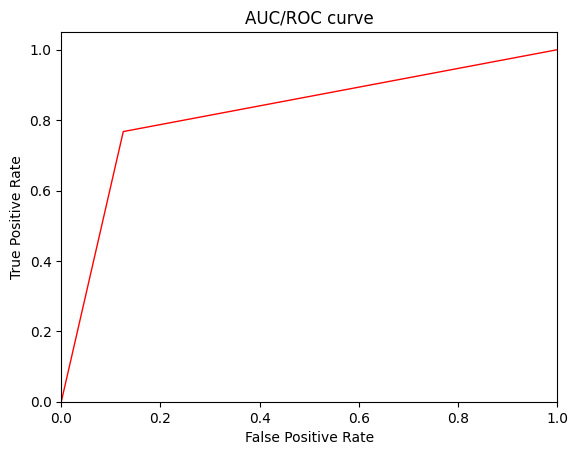

In [32]:
svm = SVC(C=50, kernel='linear')
clf1 = svm.fit(X_train, y_train.ravel())
svm_accuracy = performance_report(svm) 
modelAccuracies.append(svm_accuracy)
plot_roc_curve(svm)

### Decision tree

Primjer se klasificira slijednim ispitivanjem vrijednosti značajki, krenuvši od korijena (vrha) stabla prema dnu (listovima)  - (UUI prez10)
**Minimizacija entropije** - suma vjerojatnosti svih vrijednosti značajke s njihovim vjerojatnostima (pi * log(pi))  
**Information gain** - kolika je težina entropije svake grane na cijelom setu i onda računamo koliko je ta oduzela od prijašnje entropije (za parent značajku i njezinu vrijednost na toj grani); porast IG -> više entropije je maknuto (jer težimo prema 0) 


Acuuracy Of the Model: 0.8

Confusion Matrix:
[[31  1]
 [14 29]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.97      0.67      0.79        43

    accuracy                           0.80        75
   macro avg       0.83      0.82      0.80        75
weighted avg       0.85      0.80      0.80        75



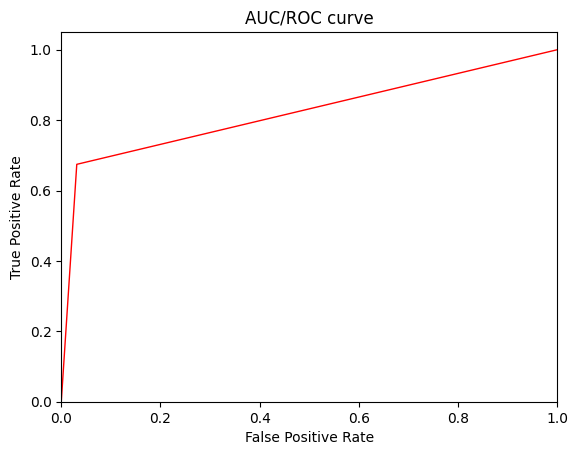

In [33]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=6)
clf2 = dtc.fit(X_train, y_train.ravel())
dtc_accuracy = performance_report(dtc) 
modelAccuracies.append(dtc_accuracy)
plot_roc_curve(dtc)

### Logistička regresija

Koristi se za klasifikaciju - y je diskretna varijabla  
Model logističke regresije koristi sigmoidnu funkciju 


Acuuracy Of the Model: 0.7866666666666666

Confusion Matrix:
[[30  2]
 [14 29]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.94      0.79        32
           1       0.94      0.67      0.78        43

    accuracy                           0.79        75
   macro avg       0.81      0.81      0.79        75
weighted avg       0.83      0.79      0.79        75



c:\Users\kkrmpotic\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


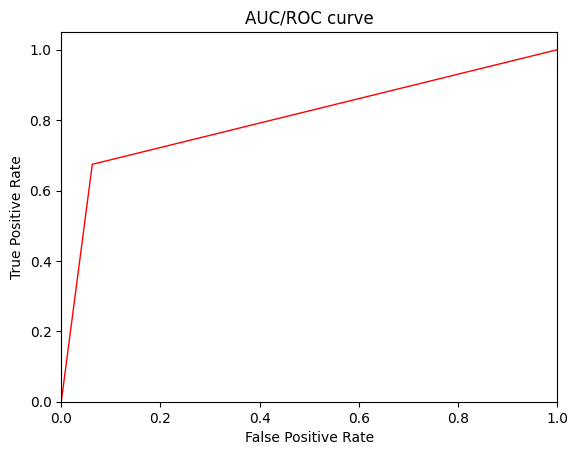

In [34]:
from sklearn import linear_model

model_features1 = ['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']
model_prediction_class1 = ['CDR']
X1 = dataset[model_features1].values
y1 = dataset[model_prediction_class1].values
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.20, random_state=44)

logRegModel = linear_model.LogisticRegression()
logRegModel.fit(X_train, y_train.ravel())
performance_report(logRegModel)
plot_roc_curve(logRegModel)


### Other models

*XGBoost*  
*Random forest classifier*  


Acuuracy Of the Model: 0.84

Confusion Matrix:
[[30  2]
 [10 33]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        32
           1       0.94      0.77      0.85        43

    accuracy                           0.84        75
   macro avg       0.85      0.85      0.84        75
weighted avg       0.86      0.84      0.84        75



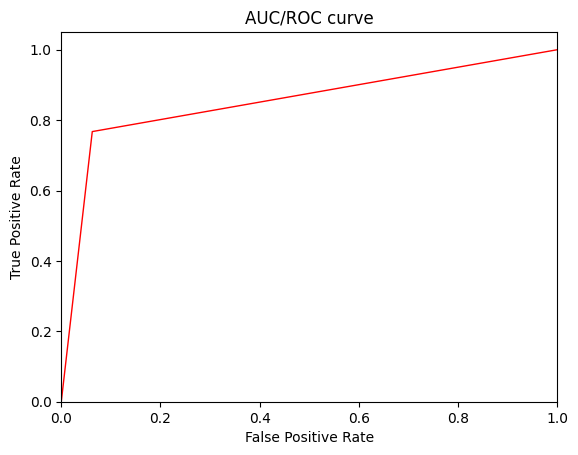

===== Random ForestClassifier =====

Acuuracy Of the Model: 0.84

Confusion Matrix:
[[31  1]
 [11 32]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.97      0.84        32
           1       0.97      0.74      0.84        43

    accuracy                           0.84        75
   macro avg       0.85      0.86      0.84        75
weighted avg       0.87      0.84      0.84        75



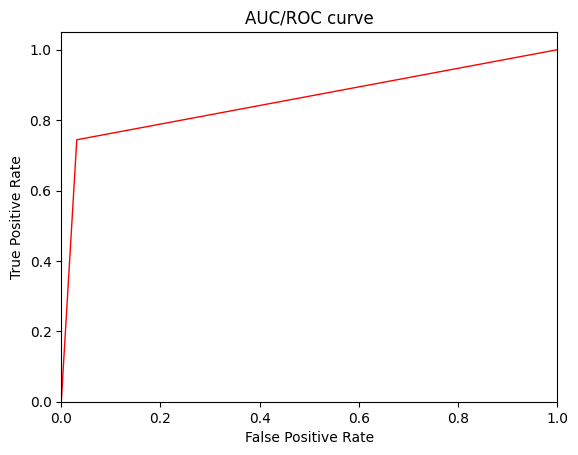

===== K-Neighbors Classifier =====

Acuuracy Of the Model: 0.64

Confusion Matrix:
[[25  7]
 [20 23]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.78      0.65        32
           1       0.77      0.53      0.63        43

    accuracy                           0.64        75
   macro avg       0.66      0.66      0.64        75
weighted avg       0.68      0.64      0.64        75



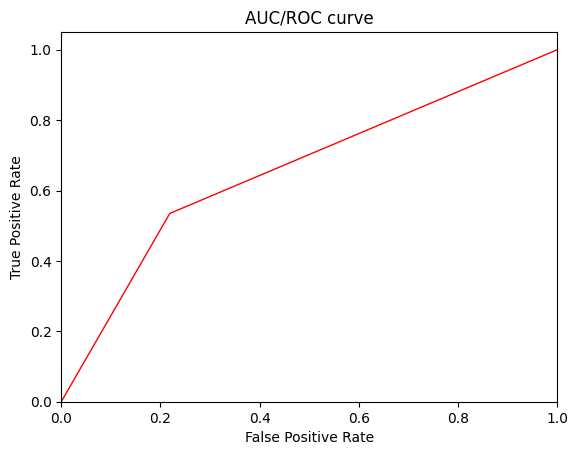

In [35]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

xgb = XGBClassifier(random_state=70)
clf4 = xgb.fit(X_train, y_train.ravel())
xgb_accuracy = performance_report(xgb)
modelAccuracies.append(xgb_accuracy)
plot_roc_curve(xgb)

print("===== Random ForestClassifier =====")

rfc = RandomForestClassifier(max_depth=5, random_state=24)
rfc.fit(X_train, y_train.ravel())
rfc_accuracy = performance_report(rfc)
modelAccuracies.append(rfc_accuracy)
plot_roc_curve(rfc)

print("===== K-Neighbors Classifier =====")

knn_class = KNeighborsClassifier(n_neighbors=4)
knn_class.fit(X_train, y_train.ravel())
knn_accuracy = performance_report(knn_class)
modelAccuracies.append(knn_accuracy)
plot_roc_curve(knn_class)


### Model comparison

SVC: 0.8133333333333334
Decision tree: 0.8
XGBoost: 0.84
Random forest classifier: 0.84
K-Neighbors Classifier: 0.64


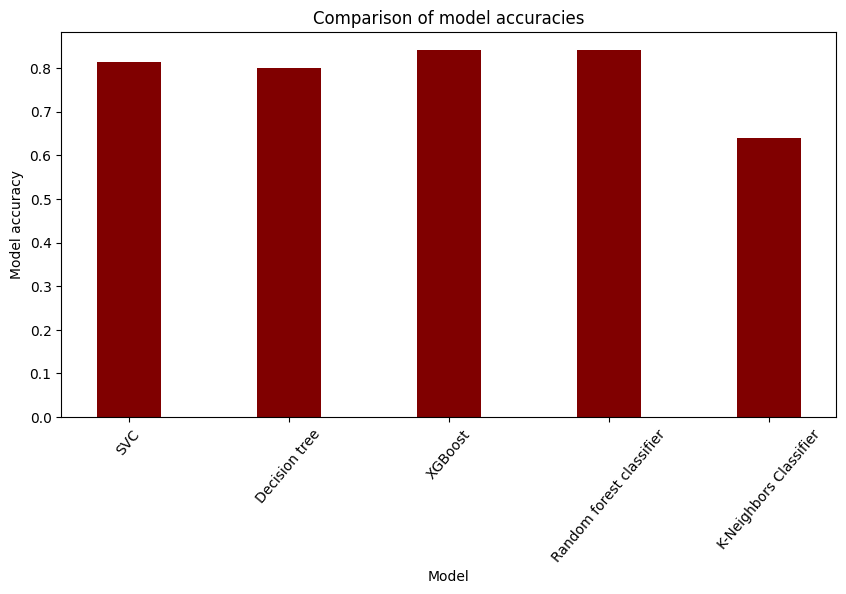

In [39]:
modelNames = np.array(['SVC', 'Decision tree', 'XGBoost', 'Random forest classifier', 'K-Neighbors Classifier'])
for i in range(len(modelNames)):
    print(str(modelNames[i]) + ": " + str(modelAccuracies[i]))

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(modelNames, modelAccuracies, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model")
plt.xticks(rotation = 50)
plt.ylabel("Model accuracy")
plt.title("Comparison of model accuracies")
plt.show()